请输入要预测的加密货币代码（如 BTC/ETH/LTC）： btc



开始处理 BTC 预测...


C:\Users\chaoh\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


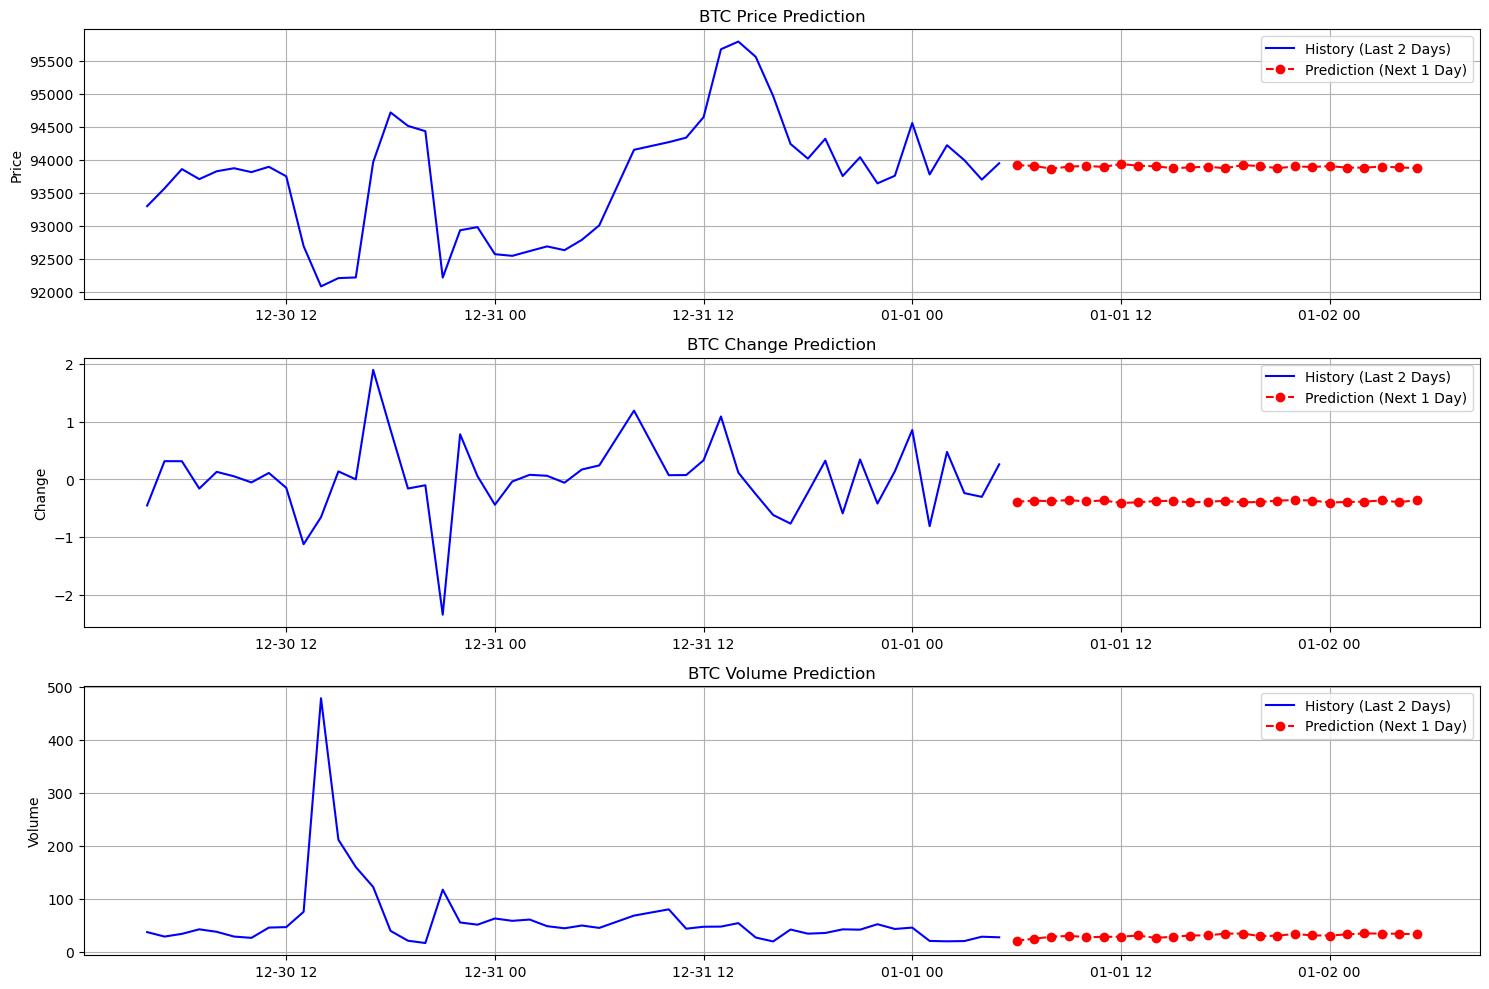


最终数据已保存至 BTC_last_hour_prediction.csv


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# 用户输入
coin = input("请输入要预测的加密货币代码（如 BTC/ETH/LTC）：").upper()
print(f"\n开始处理 {coin} 预测...")

# 加载数据（仅读取必要列）
data = pd.read_csv('8y_h_m.csv', parse_dates=['date'], index_col='date')

# 定义特征列
base_features = ['open', 'high', 'low', 'close', 'volume', 'change']
features = [f"{coin}_{f}" for f in base_features]

# 确保所有必要列存在
if not set(features).issubset(data.columns):
    raise ValueError(f"数据集中缺失必要列: {[col for col in features if col not in data.columns]}")

# 仅保留最近 7 天的数据
recent_days = 7 * 24  # 7 天数据（每小时）
data = data[features].dropna().iloc[-recent_days:]

# 数据归一化
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 时间步参数
input_steps = 168  # 过去 7 天
output_steps = 24  # 预测 1 天

# 生成输入数据（仅取最近 7 天作为输入）
X_latest = np.expand_dims(scaled_data, axis=0)

# 加载模型并进行预测
model = load_model("lstm_model.keras")
prediction_scaled = model.predict(X_latest)

# 反归一化
prediction_actual = scaler.inverse_transform(
    prediction_scaled.reshape(-1, len(features))
).reshape(output_steps, len(features))

# 生成时间索引
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(hours=1), periods=output_steps, freq='H')

# 构造预测结果 DataFrame
predicted_df = pd.DataFrame(index=future_dates, data=prediction_actual, columns=features)

# **修改可视化部分，仅显示最后 2 天的历史数据 + 预测 1 天**
history_days = 2 * 24  # 2 天数据（每小时）
historical = data.iloc[-history_days:]  # 取最后 2 天历史数据

# 结果可视化
plt.figure(figsize=(15, 10))
plot_features = [f'{coin}_close', f'{coin}_change', f'{coin}_volume']
titles = ['Price', 'Change', 'Volume']

for i, (feature, title) in enumerate(zip(plot_features, titles), 1):
    plt.subplot(3, 1, i)
    
    # 绘制历史数据（最后 2 天）
    plt.plot(historical.index, historical[feature], label='History (Last 2 Days)', color='blue')
    
    # 绘制预测数据（未来 1 天）
    plt.plot(predicted_df.index, predicted_df[feature], marker='o', linestyle='--', color='red', label='Prediction (Next 1 Day)')
    
    plt.title(f'{coin} {title} Prediction')
    plt.ylabel(title)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig(f'{coin}_prediction_visualization.png')
plt.show()

# 只保留 close, change, volume
selected_features = [f'{coin}_close', f'{coin}_change', f'{coin}_volume']

# 获取历史数据的最后 1 小时
last_history_time = historical.index[-1]
last_history_data = historical.loc[[last_history_time], selected_features]
last_history_data['type'] = 'history'

# 获取预测数据的最后 1 小时
last_prediction_time = predicted_df.index[-1]
last_prediction_data = predicted_df.loc[[last_prediction_time], selected_features]
last_prediction_data['type'] = 'prediction'

# 合并历史 + 预测数据
final_df = pd.concat([last_history_data, last_prediction_data])

# 保存 CSV
final_df.to_csv(f'{coin}_last_hour_prediction.csv')

print(f"\n最终数据已保存至 {coin}_last_hour_prediction.csv")
